In [1]:
# Import Data Wrangling Libraries
import numpy as np
import pandas as pd
from scipy import sparse

# Import Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_theme(style="darkgrid", palette="husl")

pd.set_option('display.max_rows', 30)


# Load Data Structures

In [2]:
# Load poems with targets
poems = pd.read_parquet('datasets/poems-final.parquet')

# Investigate target variables

- `sex`
- `country_of_origin`
- `dates`

In [3]:
targets = ['sex','country_of_origin','dates']

poems[targets].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13759 entries, 0 to 13758
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                13727 non-null  object 
 1   country_of_origin  8002 non-null   object 
 2   dates              7577 non-null   float64
dtypes: float64(1), object(2)
memory usage: 322.6+ KB


The `sex` and `country_of_origin` columns `object` columns.

The `dates` column is a `float64` column.

Null counts:

|column|Null Rows|Non-null Rows|
|-----|-----|-----|
|`sex`|32|13727|
|`country_of_origin`|5757|8002|
|`dates`|6182|7577|

There are a large number of null rows for `country_of_origin` and `dates`. There are still enough non-null rows to build a predictive model on, and we can potentially use the model on null rows to predict the `country_of_origin` and `dates`. This is true, also of the `sex` column, albeit with a smaller number of columns. 

For the purpose of modelling however, I will separate the null rows from the non-null rows.

In [4]:
poems[targets].describe(include = 'all')

sex country_of_origin        dates
count   13727              8002  7577.000000
unique      2                66          NaN
top      male     united_states          NaN
freq     8430              5216          NaN
mean      NaN               NaN  1909.277550
std       NaN               NaN    98.665064
min       NaN               NaN  1293.000000
25%       NaN               NaN  1902.000000
50%       NaN               NaN  1946.000000
75%       NaN               NaN  1964.000000
max       NaN               NaN  2022.000000

The above table gives a high level overview of the data in each of these columns.

##### `sex`
- 13727 non-null rows
- 2 unique non-null values within this column
- The most frequently occuring value is `male` occuring 8430 times.

-----
##### `country_of_origin`
- 8002 non-null rows
- 67 unique non-null values
- The most frequently occuring value is `united-states` occuring 5212 times.
- This means there is significant class imbalance for this target variable.

-----
##### `dates`
- 7577 non-null rows
- Mean date is 1909.27
- Median Date is 1946
- This means the dates column is negatively skewed: There are more records with a dates value above the mean than below the mean. 

-----

I will now look at each column in turn for a deeper analysis.

## `sex`

In [5]:
poems.sex.value_counts(normalize=True)

male      0.614118
female    0.385882
Name: sex, dtype: float64

The breakdown of the records between male and female are:

- 61.41% of poems were written by males.
- 38.59% of poems were written by females.

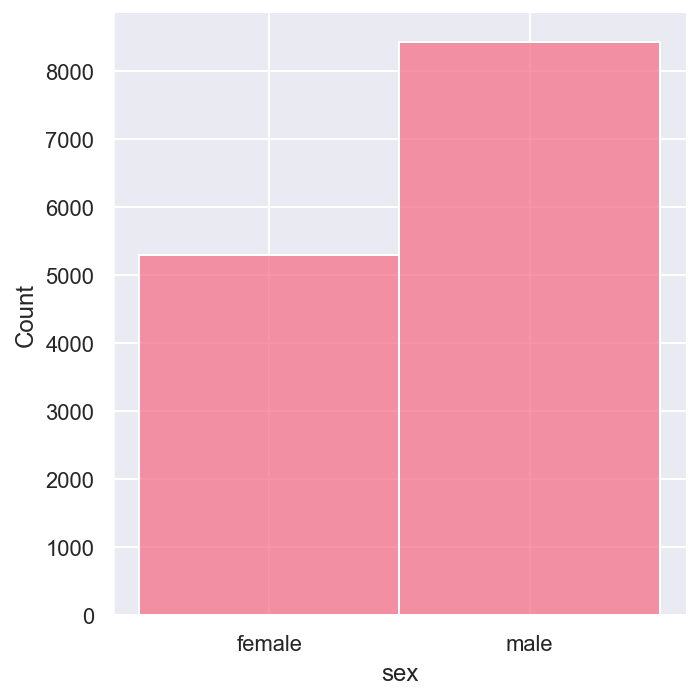

In [3]:
sex_hist = sns.displot(data = poems.sex)
fig =sex_hist.fig
fig.savefig('plots/sex_histogram.png')

The above plot visualizes the difference in how many poems are by males vs. females. It visualizes the breakdown outlined above.

We can see that there is some class imbalance within this column. To counter this I will implement the SMOTE algorithm. This algorithm creates synthetic data points based on the actual data points within the minority class. The algorithm works in the following way:

- Draw a random sample from the minority class;
- Identify the k nearest neighbors for observations in this sample;
- Identify the vector between the current data point and one of its neighbors;
- Multiply the vector by a random number between 0 & 1;
- Add this vector to the current data point to obtain the synthatic data point.

We have also identified our baseline accuracy for our model: 61.41%

If we guess male for every row, we can expect to be correct 61.41% of the time. The accuracy score of the model needs to be above this mark. (I will restate this benchmark during the modelling phase - don't feel you need to remember it.)

## `country_of_origin`

In [7]:
country_origin = pd.DataFrame(poems.country_of_origin.value_counts())

In [8]:
country_origin.head()

country_of_origin
united_states               5216
england                     1606
canada                       134
ireland                      119
scotland                      86

Looking at the above values we can already see there is significant class imbalance with the most dominant class being `united_states` with 5212 records. 

This is 3.25 times the size of the next largest class: `england` which is 12 times the size of the third largest class.

In [9]:
len(country_origin[country_origin['country_of_origin'] < 50])

57

There are also 57 countries of origin with fewer row counts than 50.

See below for a visulisation of this breakdown:

In [5]:
countries_sorted_by_freq = poems.assign(country_freq = poems.groupby('country_of_origin')['country_of_origin'].transform('count')).sort_values(['country_freq','country_of_origin'], ascending=[False,True]).loc[:,'country_of_origin']

/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_13366/1012887193.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  country_hist.set_xticklabels(labels = countries_sorted_by_freq.unique(), rotation = 90)


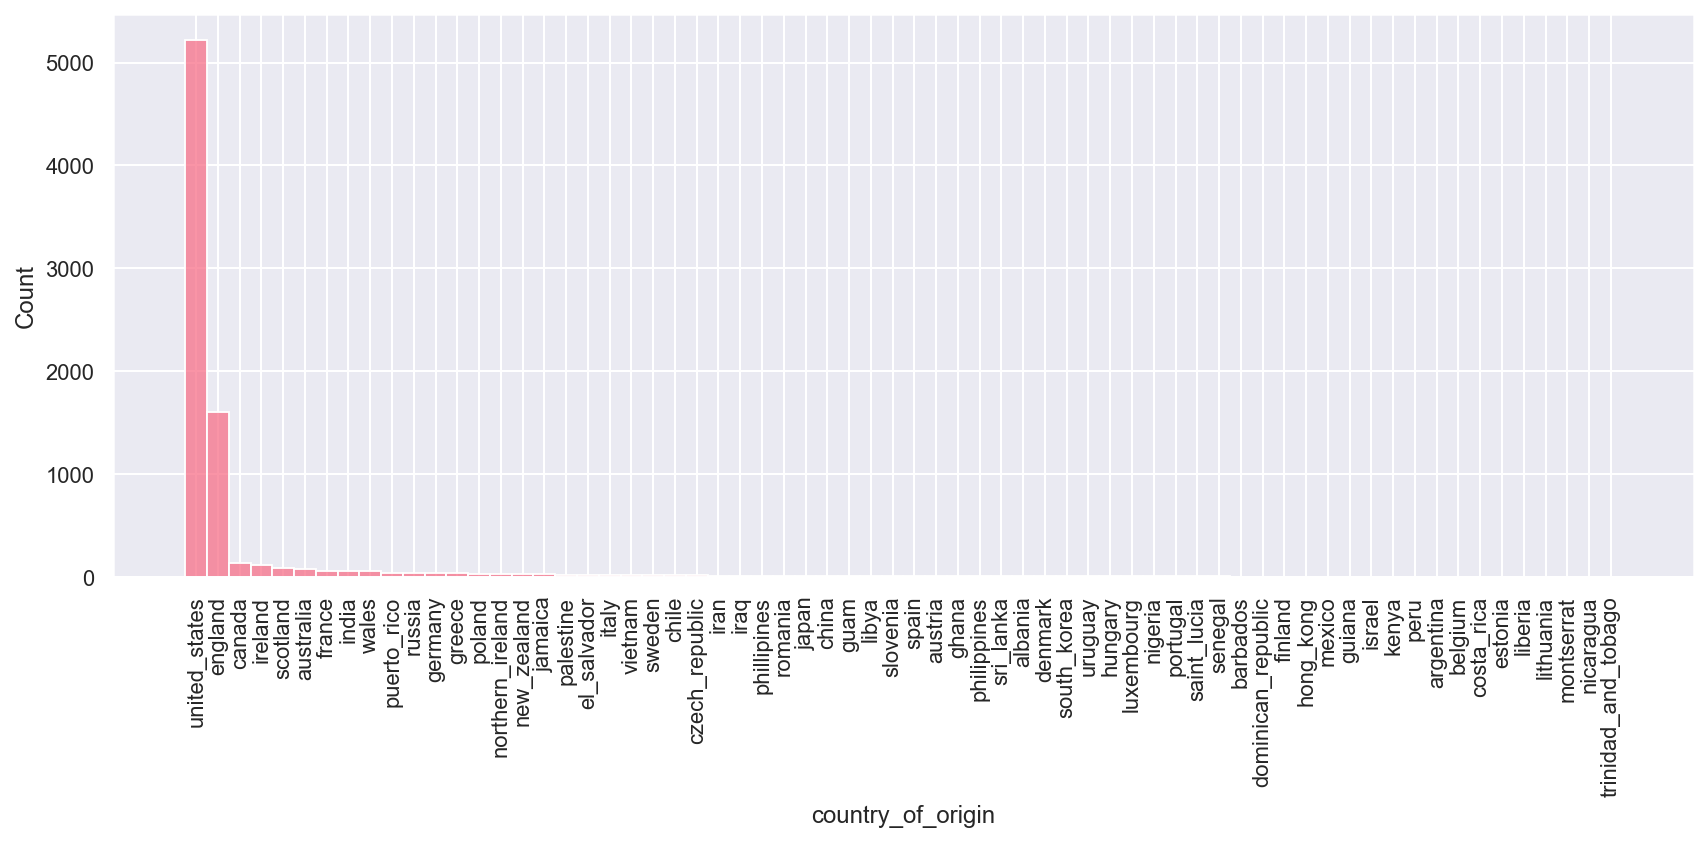

In [6]:
fig, ax = plt.subplots(figsize = (12,6))

country_hist = sns.histplot(countries_sorted_by_freq, discrete=True,stat='count', ax=ax)
country_hist.set_xticklabels(labels = countries_sorted_by_freq.unique(), rotation = 90)

plt.tight_layout()
plt.show()
fig.savefig('plots/country_histogram.png', bbox_inches = 'tight');

This visualization is effective because it shows us the scale of the dominance of the `united_states` class.

To lessen the impact of this I will do the following:

#### Aggregate countries by continent:
- North America
- South America
- Europe
- Asia
- Africa
- Oceania

The disadvantage to this approach is the model will still be dominated by North America, and Europe. The other continents do not have enough representation within the dataset.

I can still group the data points into North America, Europe and Other. This will alleviate the problem.


In [7]:
poems.country_of_origin.unique()

NA = ['united_states','puerto_rico','canada']
EU = ['germany','england','scotland','ireland','albania','sweden','poland','france','romania','northern_ireland','greece','wales','spain','czech_republic','finland','hungary','slovenia','belgium','italy','lithuania','denamrk']

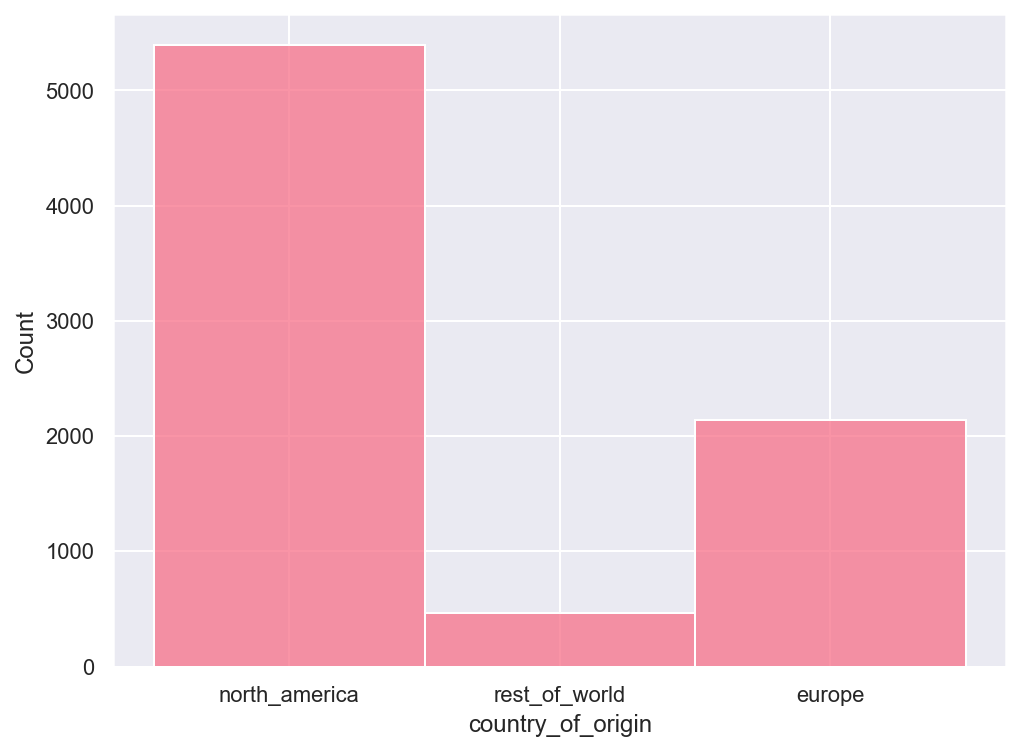

In [8]:
fig, ax = plt.subplots(figsize = (8,6))

cont_hist = sns.histplot(poems.country_of_origin.apply(lambda x: 'north_america' if x in NA else 'europe' if x in EU else 'rest_of_world' if x is not None else x), ax=ax)
fig.savefig('plots/continent_histogram.png', bbox_inches='tight');

After looking at the distributions by continent, I will change the country_of_origin target variable and try to predict if the poet is European or North American.

I think the class imbalance is too strong to be able to train the model to predict any country other than united_states using only NLP.



In [14]:
poems['continent'] = poems.country_of_origin.apply(lambda x: 'north_america' if x in NA else 'europe' if x in EU else 'other' if x is not None else x).copy()

## `dates`

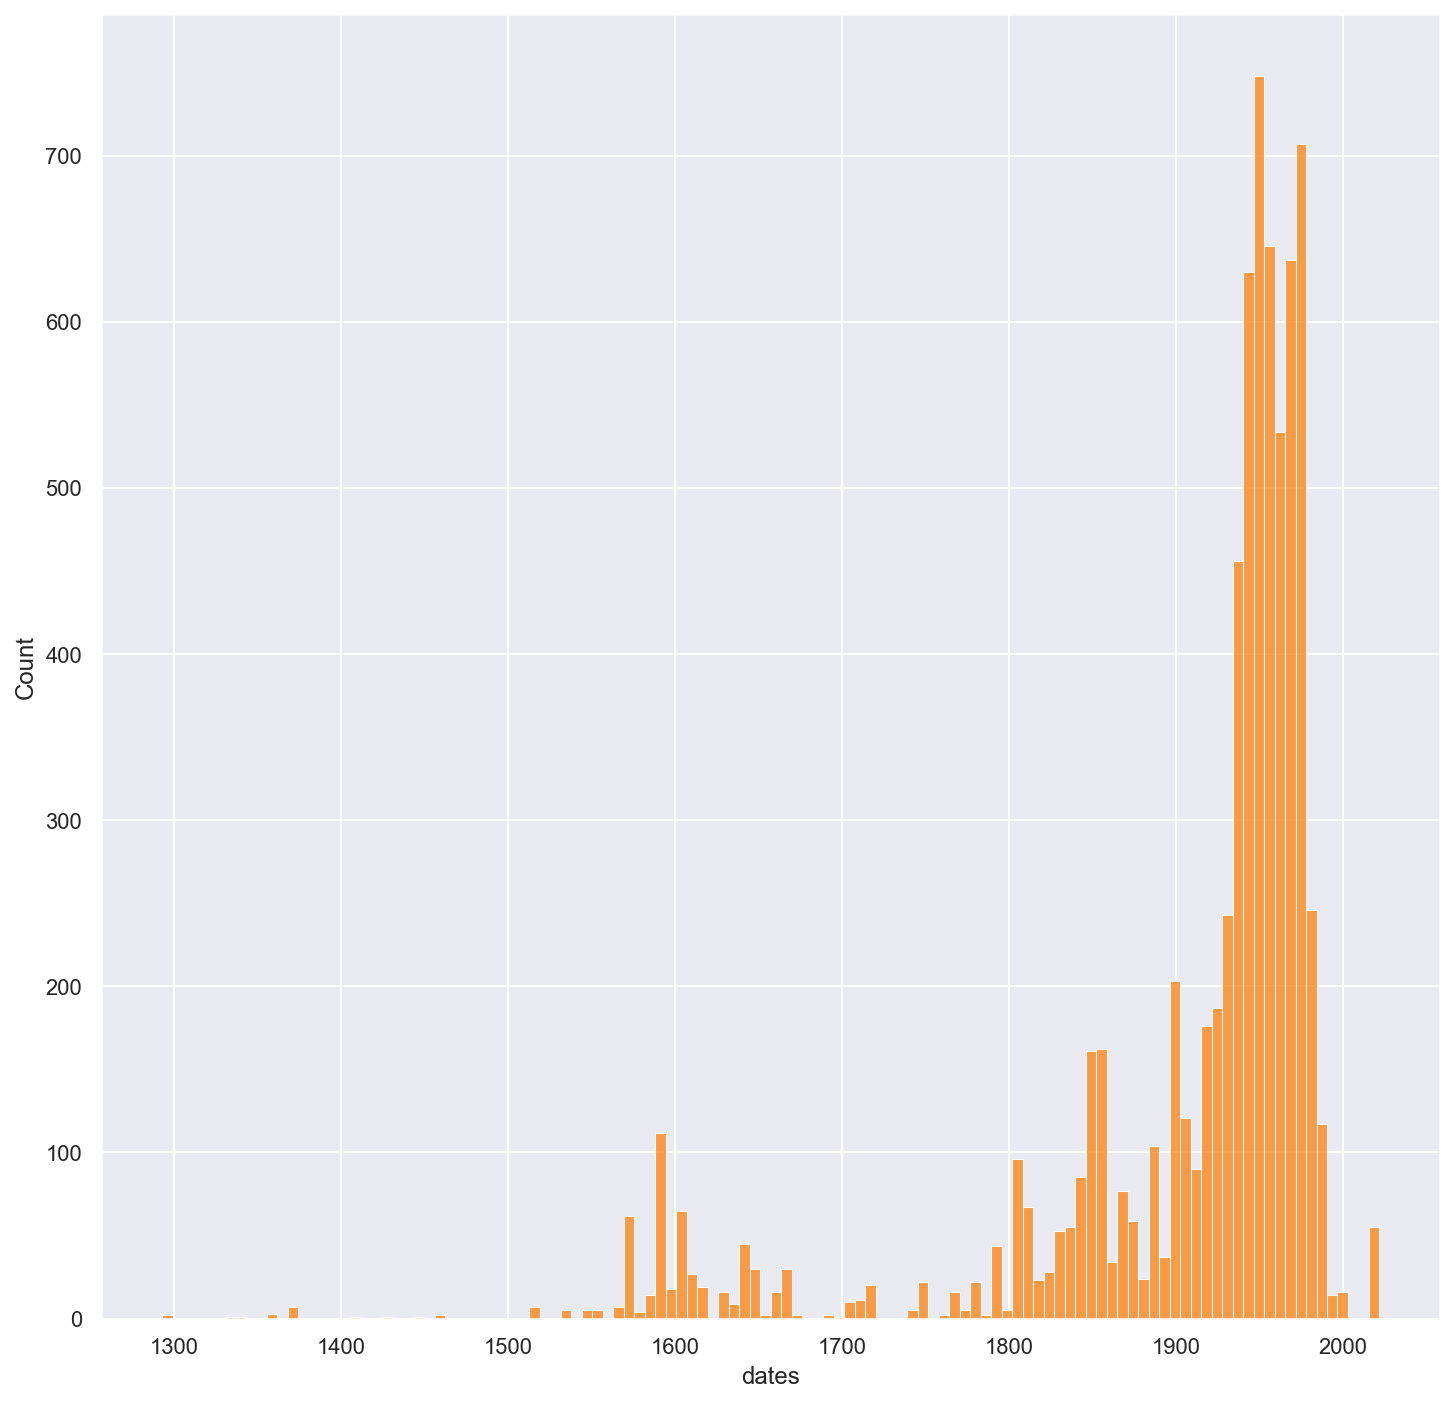

In [9]:
fig, ax = plt.subplots(figsize=(12,12))

sns.histplot(poems.dates, color = 'tab:orange', ax=ax)
fig.savefig('plots/dates_histogram.png', bbox_inches='tight');


We can see this distribution is left-skewed, with most values falling between 1900 and 2000. The earliest recorded poet within the dataset dates back to pre-1300, with records being sparse for poets up to approximately 1600. We can view this more easily using a boxplot. Before plotting the boxplot, I will scale the variables to state them in terms of their standard deviation from the mean - this will not impact the distrbution.

_n.b There is a largish bar above 2000: this will contain poets whose dates value is set to 2022. This was the value input for poets without dates listed but were confirmed as still living._

In [11]:
def var_standardize(var):
    var_stand = (var-var.mean())/var.std()
    return var_stand

In [12]:
poems['dates_z'] = var_standardize(poems.dates)

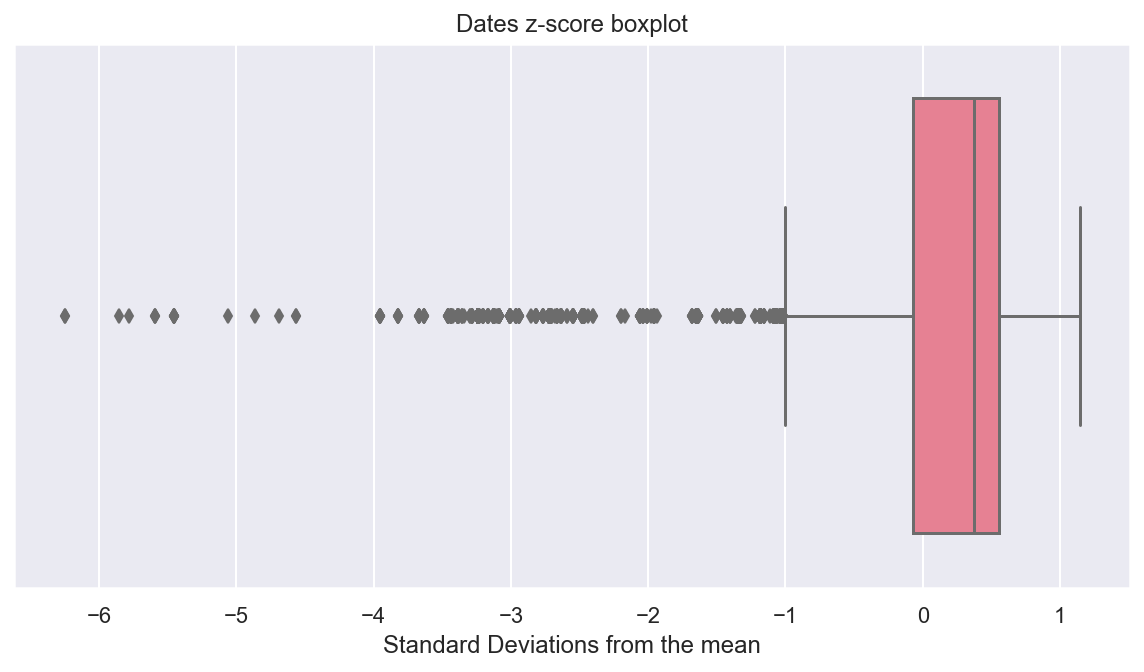

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Dates z-score boxplot')

sns.boxplot(data = poems, x = 'dates_z', ax = ax)
ax.set_xlabel('Standard Deviations from the mean')
plt.show()
fig.savefig('plots/dates_box.png', bbox_inches='tight');

This plot tells us the following things:
- The data set is negatively skewed
- There are no values greater than 2 s.d. above the mean
- There are 9 values which are more than 4 s.d. below the mean.

I will investigate these values now:

In [20]:
poems[poems['dates_z'] < -4][['poet','dates']].values

array([['Geoffrey Chaucer', 1371.5],
       ['William Dunbar', 1459.0],
       ['William Langland', 1332.0],
       ['Geoffrey Chaucer', 1371.5],
       ['John Lydgate', 1410.0],
       ['William Dunbar', 1459.0],
       ['Dante Alighieri', 1293.0],
       ['Petrarch', 1339.0],
       ["Charles d'Orleans", 1429.5],
       ['François Villon', 1447.0],
       ['Hafez', 1357.5],
       ['Hafez', 1357.5],
       ['Dante Alighieri', 1293.0],
       ['Hafez', 1357.5],
       ['Geoffrey Chaucer', 1371.5],
       ['Geoffrey Chaucer', 1371.5],
       ['Geoffrey Chaucer', 1371.5],
       ['Geoffrey Chaucer', 1371.5],
       ['Geoffrey Chaucer', 1371.5]], dtype=object)

Having investigated these values and checking the dates these poets were alive, I can confirm they are legitimate values. Therefore I will not remove them from the dataset.

Indeed, for this project it is good to have these poets in the dataset because it will prove an interesting analysis if a model can identify how language usage changes over time.

# Assess top words and punctuation per category for `sex` and `continent`

## `sex`

In [14]:
from wordcloud import WordCloud,STOPWORDS

### Words

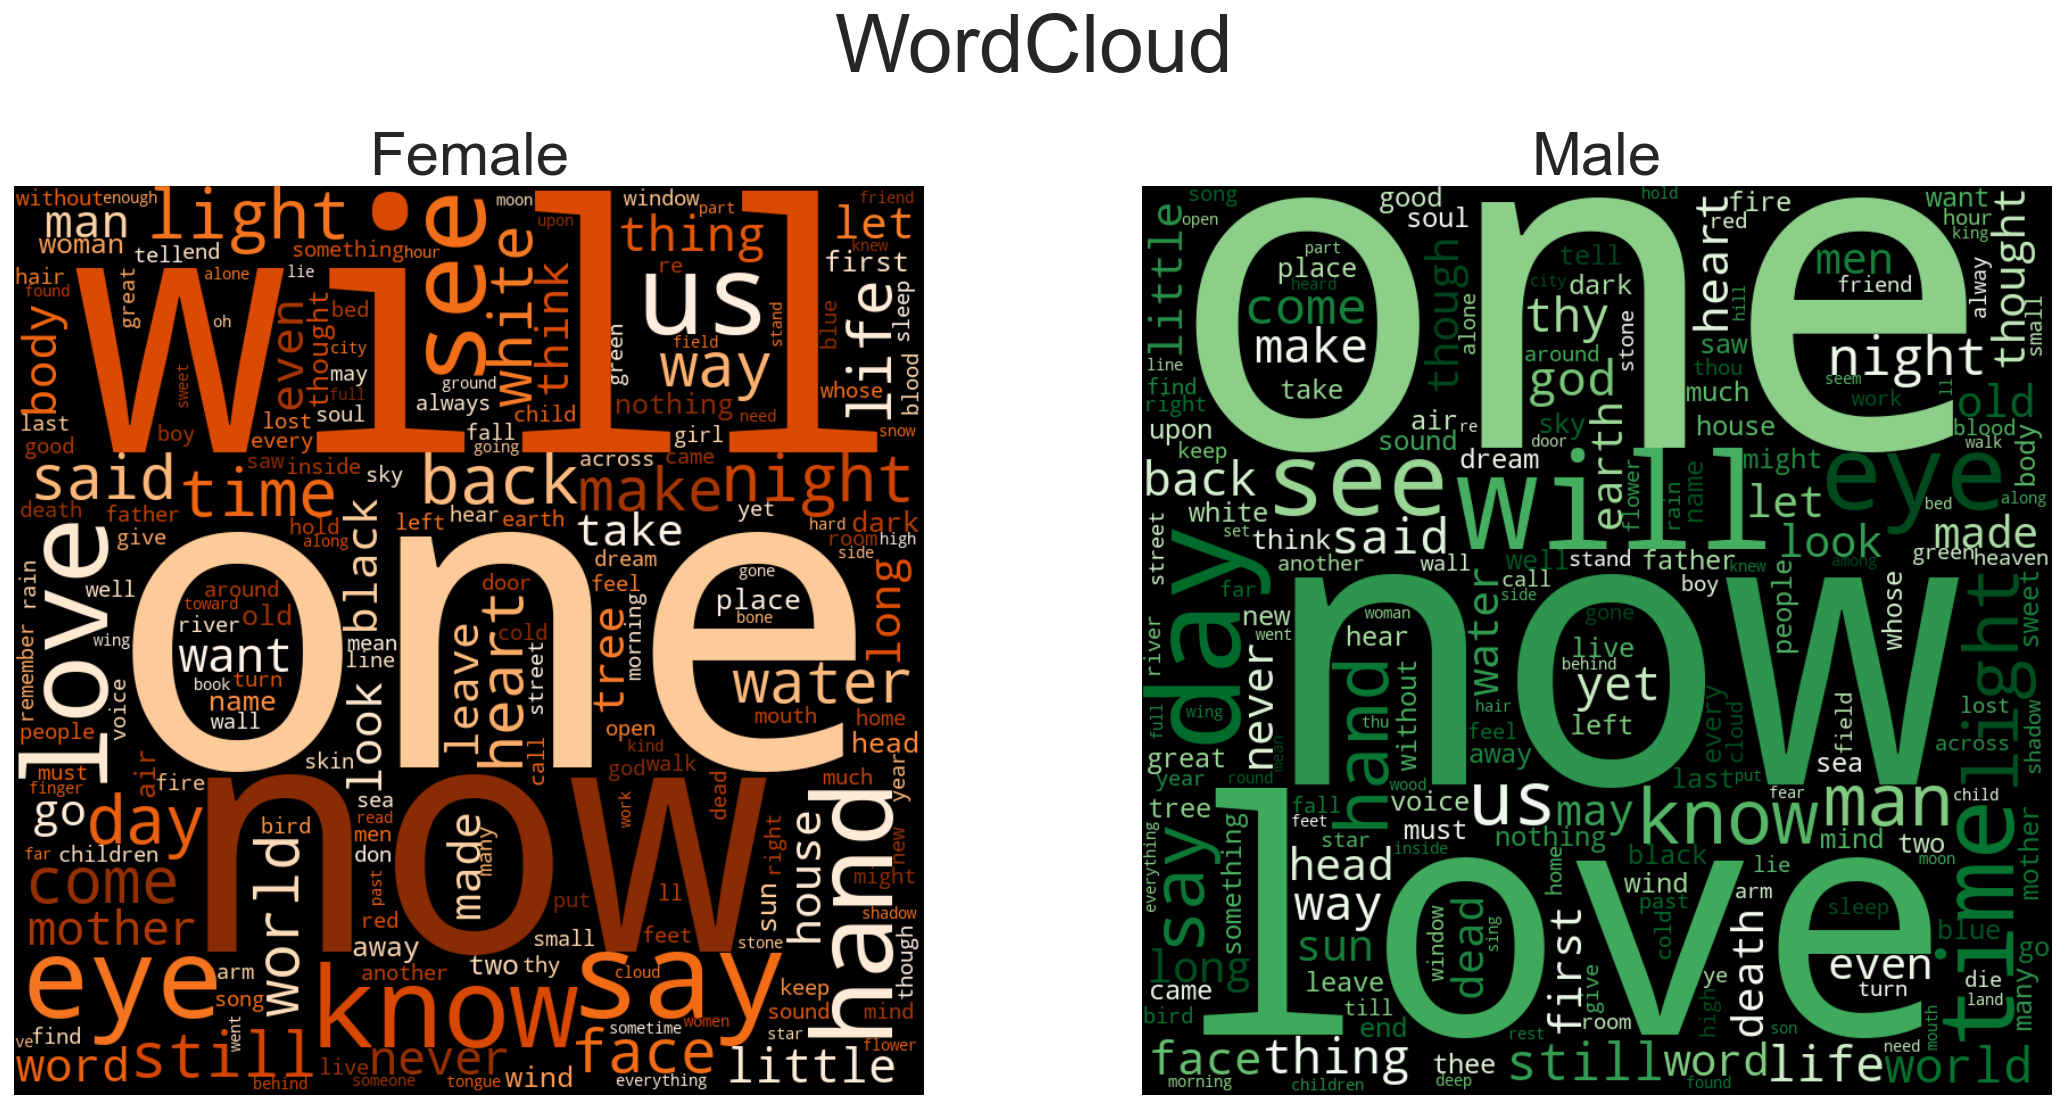

In [23]:
stopwords = STOPWORDS

fig, ax = plt.subplots(ncols = 2, figsize = (16,8))

for index, sex in enumerate(poems.sex.unique()):
    comment_words = ''

    if sex is not None:
        for poem in poems[poems.sex == sex]['poem'].values:
            comment_words += poem.lower()
        
        if sex == 'female':
            color = 'Oranges'
        else:
            color = 'Greens'

        wordcloud = WordCloud(width = 800, height = 800,
                            background_color = 'black',
                            stopwords = stopwords,
                            min_font_size = 12, colormap = color,
                            regexp = r'\w{2,}[\'\-]?\w*').generate(comment_words)

        ax[index].imshow(wordcloud, interpolation = 'bilinear')
        ax[index].axis("off")
        ax[index].set_title(f'{sex.capitalize()}', fontsize = 30)
        
    else:
        pass

plt.suptitle('WordCloud', fontsize = 40)
plt.tight_layout(pad = 2)
plt.show();

The above word clouds show us which words, broadly speaking, feature most heavily for Male and Female poets. We can use this to get a high-level feeling for similarities and differences:
- 'Now', 'love' and 'eye' are dominant words for each sex
- Male poets use the words 'man' and 'time' more frequently than female poets
- There is no clear distinction between which words males use vs. females from these charts.

I will recreate these wordclouds, but I will aim to remove the most dominant words across both sexes to identify if there are differences further down.

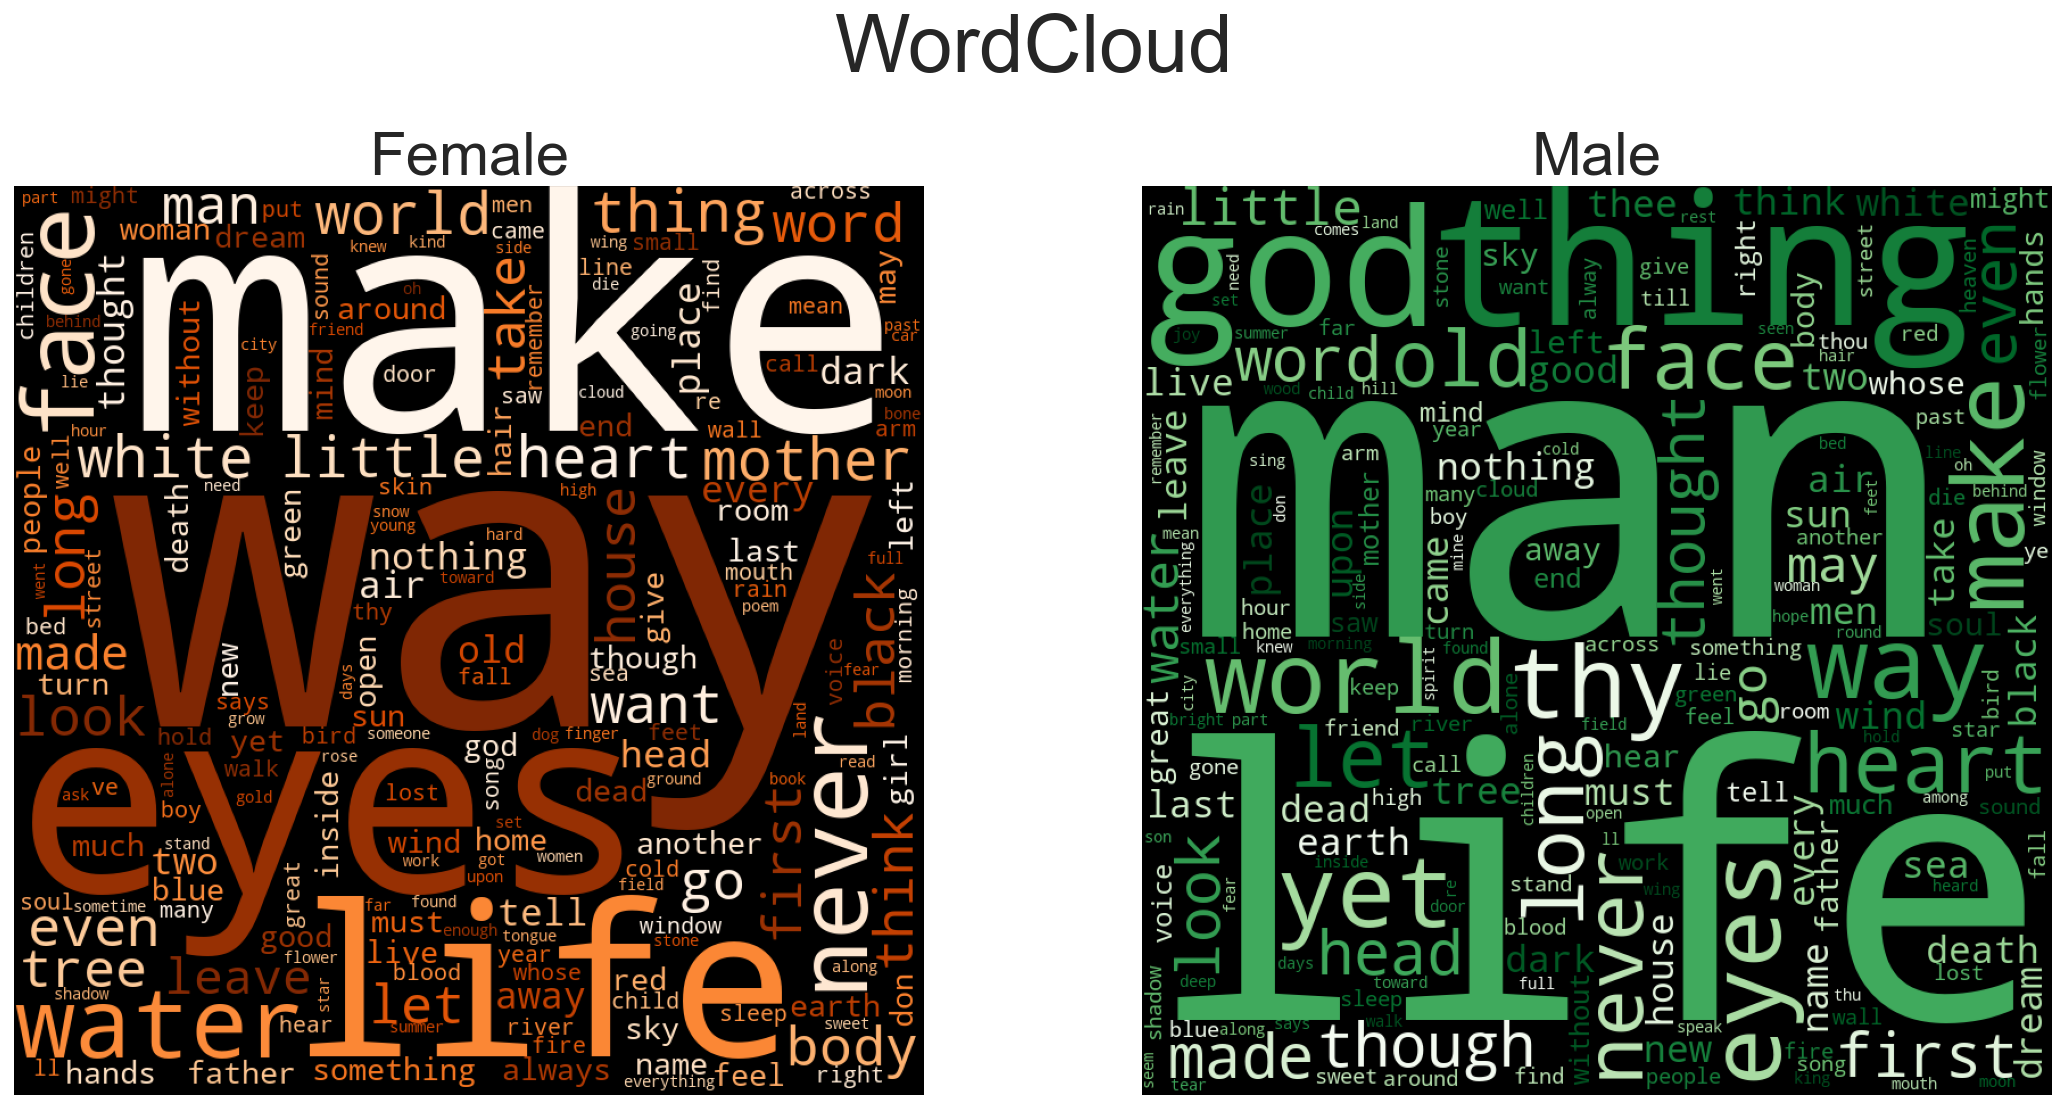

In [15]:
# Add words to stopwords list to filter out dominant words across both sexes
stopwords = STOPWORDS.update(['now','know','eye','hand','love', 'day', 'see','will','one','see', 'light', 'say','back','us','time','come','night','still','said'])

# Initialize matplotlib figure and axes to plot multiple plots at the same time
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))

# Iterate through both sexes in poems and track index
for index, sex in enumerate(poems.sex.unique()):

    # Initialize empty string
    poem_words = ''

    # Check if sex is None
    if sex is not None:

        # Iterate through all poems for given sex
        for poem in poems[poems.sex == sex]['poem'].values:
            # Add lower case words of poem to poem_words
            poem_words += poem.lower()
        
        # Set colour of wordcloud based on sex
        if sex == 'female':
            color = 'Oranges'
        else:
            color = 'Greens'

        # Create wordcloud using words in poem_words
        # Set width and height to 800
        # Set background colour to black
        # Set stopwords to stopwords list defined above
        # Set minimum font size to 12
        # Set color to color defined above by sex
        # Set regular expression to tokenize words
        wordcloud = WordCloud(width = 800, height = 800,
                            background_color = 'black',
                            stopwords = stopwords,
                            min_font_size = 12, colormap = color,
                            regexp = r'\w{2,}[\'\-]?\w*', include_numbers = True).generate(poem_words)

        # Plot wordcloud on axes based on index for sex
        ax[index].imshow(wordcloud)

        # Turn x and y axis off
        ax[index].axis("off")

        # Add ttitle to subplot to differentiate between wordclous
        ax[index].set_title(f'{sex.capitalize()}', fontsize = 30)
        
    else:
        # If sex is None, move on
        pass

# Set title for total plot
plt.suptitle('WordCloud', fontsize = 40)

# Prevent overlapping by setting to tight layout
plt.tight_layout(pad = 2)

# Show plot
plt.show()

# Save plot to .png
fig.savefig('plots/sex_clouds.png', bbox_inches = 'tight');

After removing the more dominant words, we can see the following:
- The words 'man' and 'thing' are used more predominantly by males.
- Female poets seem use the words 'way' amd 'make' with more frequency.
- Female poets use the word 'mother' far more than male poets.

We can see there is great similarity between the sexes, but there is also some difference. We can throw more light on this when we build the model.

### Punctuation

A key element of poetry is how punctuation is used - this can carry a lot of meaning. In view of this, I want to see if there is any distinction between how the sexes use punctuation.

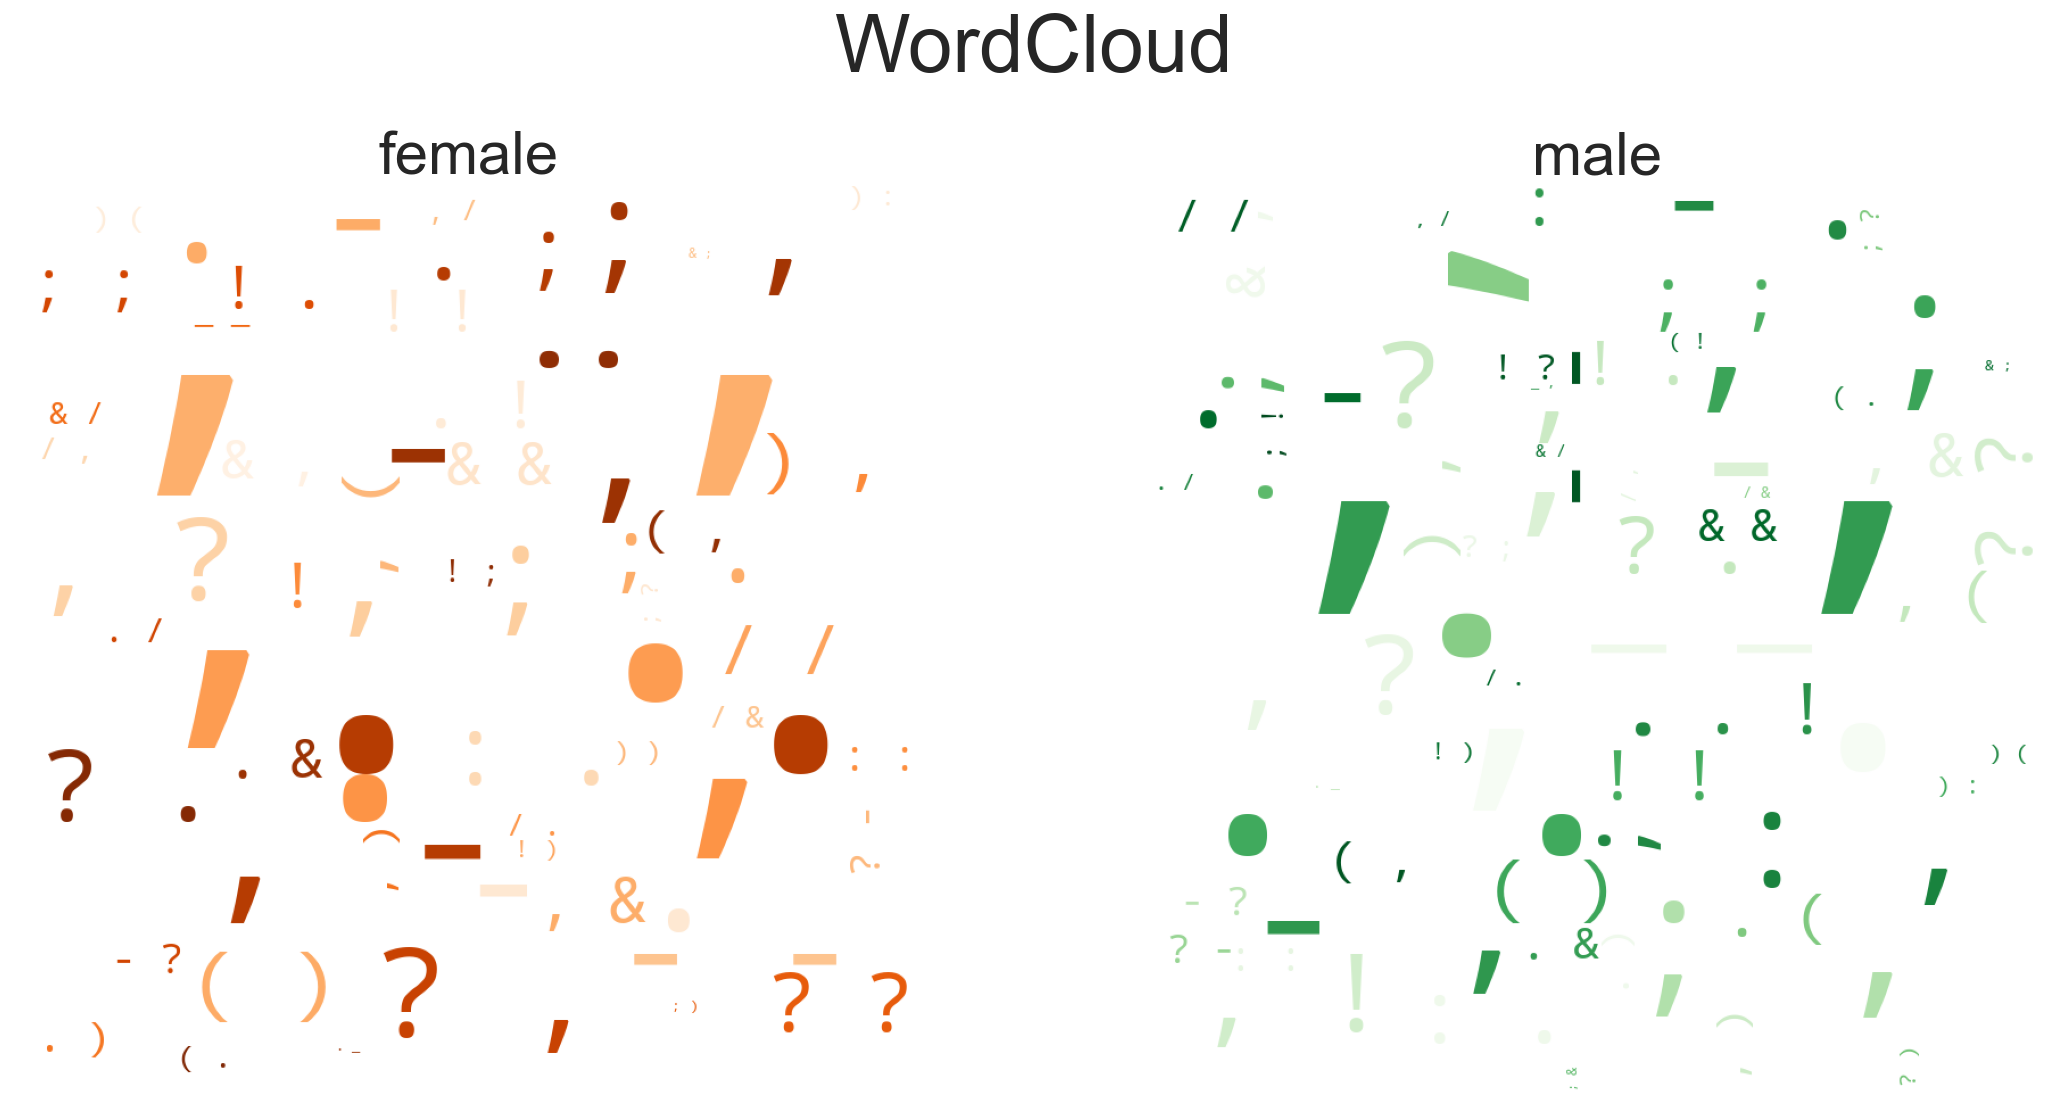

In [32]:
stopwords = STOPWORDS

fig, ax = plt.subplots(ncols = 2, figsize = (16,8))

for index, sex in enumerate(poems.sex.unique()):
    comment_words = ''

    if sex is not None:
        for poem in poems[poems.sex == sex]['poem'].values:
            comment_words += poem.lower()
        
        if sex == 'female':
            color = 'Oranges'
        else:
            color = 'Greens'

        wordcloud = WordCloud(width = 800, height = 800,
                            background_color = 'white',
                            stopwords = stopwords,
                            min_font_size = 12, colormap = color,
                            regexp = r'[.,/\\\-?;:!_()&]').generate(comment_words)

        ax[index].imshow(wordcloud)
        ax[index].axis("off")
        ax[index].set_title(f'{sex}', fontsize = 30)
        
    else:
        pass

plt.suptitle('WordCloud', fontsize = 40)
plt.tight_layout(pad = 2)
plt.show();

Unsurprisingly, it is not easy to identify a difference from the word cloud alone.

## `continent`

### Words

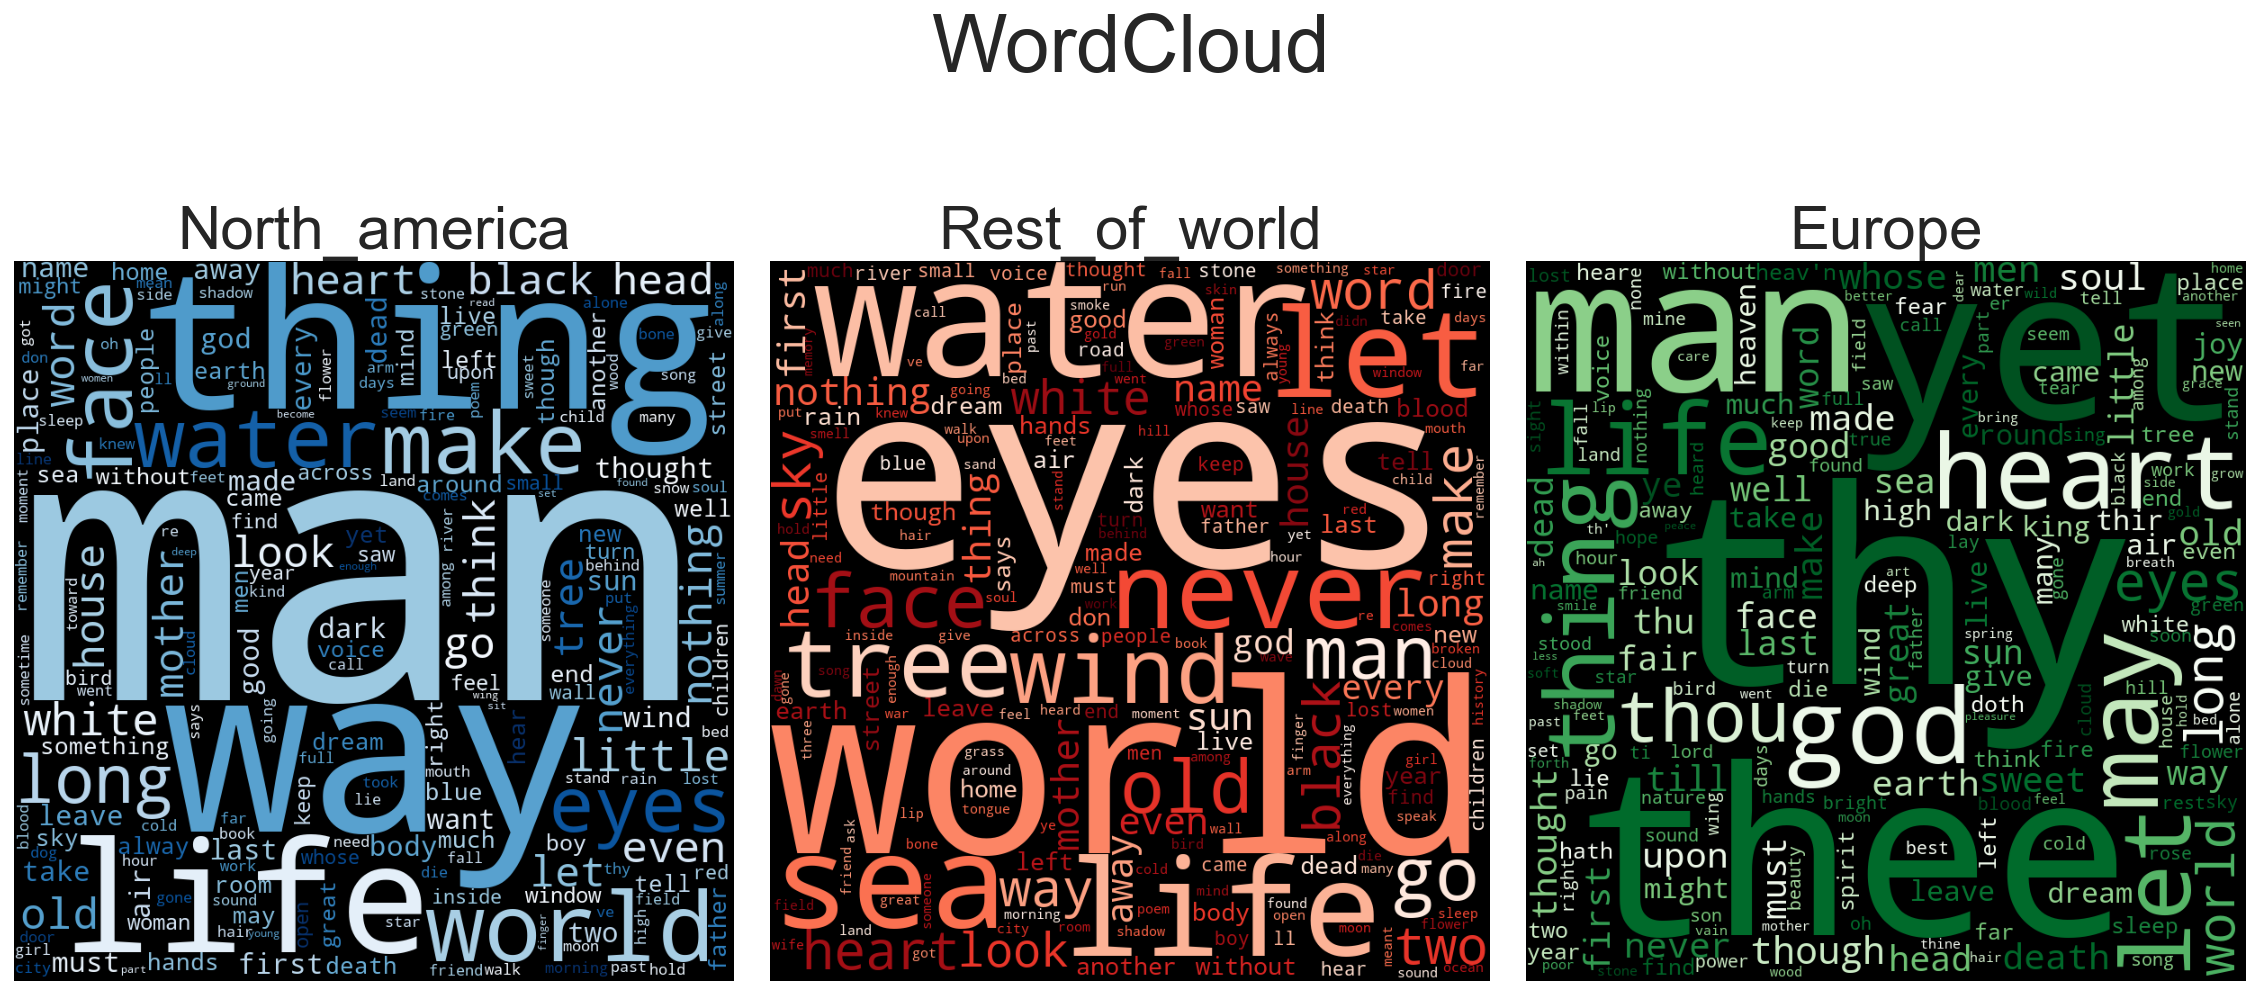

In [16]:
stopwords = STOPWORDS.update(['now','know','eye','hand','love', 'day', 'see','one','will','say','us','time'])

fig, ax = plt.subplots(ncols = 3, figsize = (16,8))

colormaps = ['Blues','Reds','Greens']

for index, continent in enumerate(poems[~poems.continent.isnull()].continent.unique()):
    comment_words = ''

    if continent is not None:
        for poem in poems[poems.continent == continent]['poem'].values:
            comment_words += poem.lower()

        wordcloud = WordCloud(width = 800, height = 800,
                            background_color = 'black',
                            stopwords = stopwords,
                            min_font_size = 12, colormap = colormaps[index],
                            regexp = r'\w{2,}[\'\-]?\w*').generate(comment_words)

        ax[index].imshow(wordcloud)
        ax[index].axis("off")
        ax[index].set_title(f'{continent.capitalize()}', fontsize = 30)
        
    else:
        pass

plt.suptitle('WordCloud', fontsize = 40)
plt.tight_layout(pad = 1.5)
plt.show()
fig.savefig('plots/continent_clouds.png', bbox_inches = 'tight');

We can see the following insights from the above word clouds:
- The Europe word cloud is dominated by the words 'thee' and 'thy' - these are archaic terms, which make sense since England was the epicentre for poetry in the literary canon until the early 20th century.
- 'Light' is a dominant word for North America, and it does not feature as heavily in Europe and the rest of the world.
- 'God; is more dominant word for Europe, whereas it is less dominant for North America and the rest of the world.

These word clouds are useful for showcasing that there are distinctions in terms of how language is used across geographical locations.

More useful is the TF-IDF score for each word, broken down by region. Unfortunately, I do not have the computing power to complete this. 

## Predictors: `number_of_lines`, `number_of_stanzas`

### `number_of_lines`

In [39]:
poems.number_of_lines.describe()

count    13759.000000
mean        27.231776
std         49.307603
min          1.000000
25%          1.000000
50%         16.000000
75%         33.000000
max       1344.000000
Name: number_of_lines, dtype: float64

The above table shows that the maximum number of lines for this dataset is 1344. This is a large number of lines for a poem and must be investigated further. 

There are a large number of values with only one line which is dominating the dataset - these will need to be confirmed.

The mean for this dataset is higher than the median, meaning the dataset has a negative skew:

/Users/PatrickPagni/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


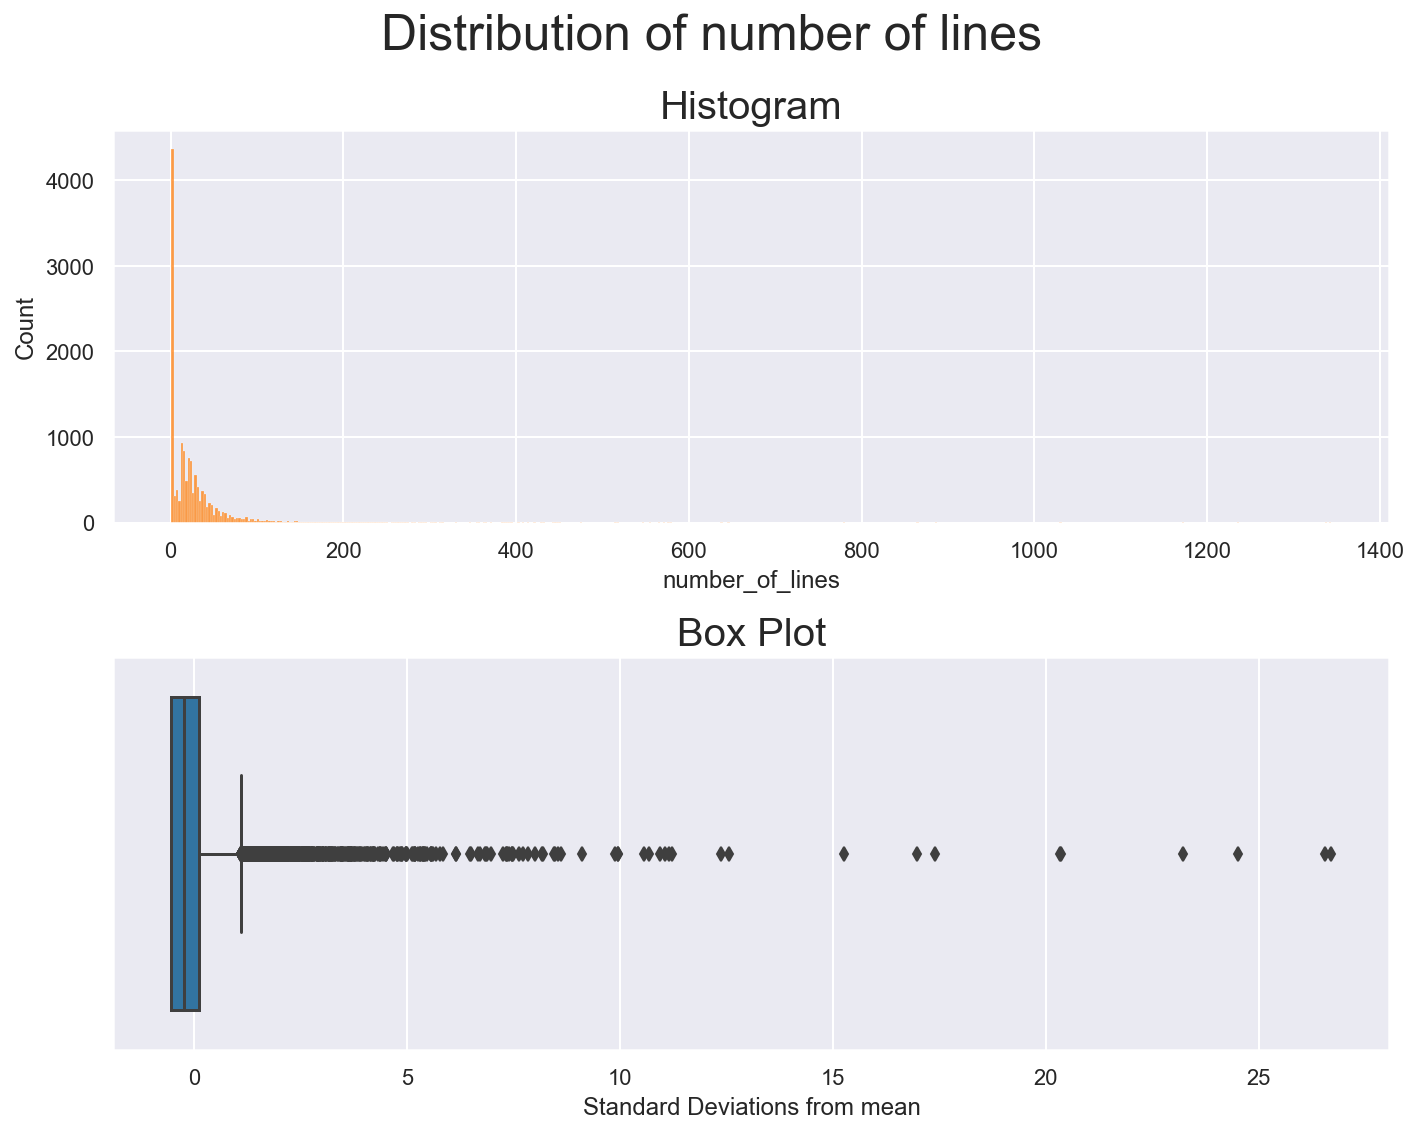

In [43]:
fig, ax = plt.subplots(nrows = 2, figsize = (10,8))

sns.histplot(poems.number_of_lines, color = 'tab:orange', ax=ax[0])
sns.boxplot(var_standardize(poems.number_of_lines), color = 'tab:blue', ax=ax[1])

ax[0].set_title('Histogram', fontsize = 20)
ax[1].set_title('Box Plot', fontsize = 20)

ax[1].set_xlabel('Standard Deviations from mean')

plt.suptitle('Distribution of number of lines', fontsize = 25)
plt.tight_layout()
plt.show();

The above is a visualization of the dominance of poems with few lines with 4000 counts. Equally, we have records with many lines with some poems having a number of lines which are greater than 25 satbdard deviations from the mean.

Firstly, I will investigate further the poems with few lines:

In [51]:
poems[(poems.number_of_lines < 3)]

title  \
6                                         Invisible Fish   
7                          Don’t Bother the Earth Spirit   
9                 ["Hour in which I consider hydrangea"]   
80     from What the Heart Longs For When It Only Kno...   
112          Seventh Sphere (Saturn: The Contemplatives)   
...                                                  ...   
13736                                            Descent   
13737                                   Captain, Captive   
13738                                         Apotheosis   
13744         Address: The Archaeans, One Cell Creatures   
13755                                          Stomackes   

                                                    poem  \
6       Invisible fish swim this ghost ocean now desc...   
7       Don’t bother the earth spirit who lives here....   
9       Hour in which I consider hydrangea, a salt or...   
80      We spend the afternoon together watching a do...   
112     No more hangings, no more gas chambers. No on...   
...                                                  ...   
13736   My father drummed darkness  Through the under...   
13737   Of your fate  Fast asleep  On the bed you mad...   
13738   Taut with longing  You must become  The god y...   
13744   Although most are totally naked  and too scan...   
13755      We know far more about the philosophical u...   

                       poet country_of_origin   dates     sex  \
6                 Joy Harjo     united_states  1951.0  female   
7                 Joy Harjo     united_states  1951.0  female   
9              Simone White              None     NaN  female   
80     Sueyeun Juliette Lee              None     NaN  female   
112           Sun Yung Shin              None     NaN  female   
...                     ...               ...     ...     ...   
13736        Samuel Menashe              None     NaN    male   
13737        Samuel Menashe              None     NaN    male   
13738        Samuel Menashe              None     NaN    male   
13744       Pattiann Rogers              None     NaN  female   
13755      Albert Goldbarth     united_states  1948.0    male   

       number_of_lines  number_of_stanzas  sorrow_and_grieving  \
6                    1                  1                  0.0   
7                    1                  1                  0.0   
9                    1                  1                  0.0   
80                   1                  1                  0.0   
112                  1                  1                  0.0   
...                ...                ...                  ...   
13736                1                  1                  0.0   
13737                1                  1                  NaN   
13738                1                  1                  0.0   
13744                1                  1                  0.0   
13755                2                  1                  0.0   

       war_and_conflict  ...  christianity  the_spiritual  \
6                   0.0  ...           0.0            0.0   
7                   0.0  ...           0.0            1.0   
9                   0.0  ...           0.0            0.0   
80                  0.0  ...           0.0            0.0   
112                 0.0  ...           0.0            0.0   
...                 ...  ...           ...            ...   
13736               0.0  ...           0.0            0.0   
13737               NaN  ...           NaN            NaN   
13738               0.0  ...           0.0            0.0   
13744               0.0  ...           0.0            0.0   
13755               0.0  ...           1.0            1.0   

       language_and_linguistics  desire  valentine's_day  weather  \
6                           0.0     0.0              0.0      0.0   
7                           0.0     0.0              0.0      0.0   
9                           0.0     0.0              0.0      0.0   
80                        

The sample of poetry shown above gives me confidence that many of these 'one line' poems are complete poems. It is possible the format of these poems do not conform to typical poetic traditions. Additionally, there is a form of poetry called prose poetry, where the poem does not fit into the usual structure of stanzas, and is more free form.

Now, I will investigate the more extreme outliers with large number of lines.

In [52]:
poems[var_standardize(poems.number_of_lines) > 6]

title  \
330                 Homo Antarcticus   
349                    Being Serious   
818              Bridge of the World   
844                           Erinna   
912     The Comedian as the Letter C   
...                              ...   
11316    The Third Hour of the Night   
12483              Sohrab and Rustum   
12573        The Prisoner of Chillon   
12888            The Triumph of Life   
12994  Song of Myself (1892 version)   

                                                    poem  \
330        "The wild will keep calling and calling fo...   
349     I. Serious smiles a lot. At least that’s what...   
818     this morning I went to the doctor and talked ...   
844         Was she of spirit race, or was she one Of...   
912                                        i         ...   
...                                                  ...   
11316   When the eye  When the edgeless screen receiv...   
12483      An Episode    AND the first grey of mornin...   
12573   My hair is grey, but not with years,       No...   
12888   Swift as a spirit hastening to his taskOf glo...   
12994   1 I celebrate myself, and sing myself, And wh...   

                             poet country_of_origin   dates     sex  \
330            Luljeta Lleshanaku           albania  1968.0  female   
349               Christian Wiman     united_states  1966.0    male   
818              Roberto Harrison              None     NaN    male   
844      Letitia Elizabeth Landon           england  1820.0  female   
912               Wallace Stevens     united_states  1917.5    male   
...                           ...               ...     ...     ...   
11316                Frank Bidart     united_states  1939.0    male   
12483              Matthew Arnold           england  1855.0    male   
12573  Lord Byron (George Gordon)              None     NaN    male   
12888        Percy Bysshe Shelley           england  1807.0    male   
12994                Walt Whitman     united_states  1855.5    male   

       number_of_lines  number_of_stanzas  sorrow_and_grieving  \
330                518                 73                  0.0   
349                864                 91                  0.0   
818                572                191                  0.0   
844                414                 16                  0.0   
912                577                  2                  0.0   
...                ...                ...                  ...   
11316             1236                481                  0.0   
12483              885                  1                  0.0   
12573              392                  1                  1.0   
12888              548                  1                  0.0   
12994             1344                  1                  0.0   

       war_and_conflict  ...  christianity  the_spiritual  \
330                 0.0  ...           0.0            0.0   
349                 0.0  ...           0.0            0.0   
818                 0.0  ...           0.0            0.0   
844                 0.0  ...           0.0            0.0   
912                 0.0  ...           0.0            0.0   
...                 ...  ...           ...            ...   
11316               0.0  ...           0.0            0.0   
12483               1.0  ...           0.0            0.0   
12573               0.0  ...           0.0            0.0   
12888               0.0  ...           0.0            0.0   
12994               1.0  ...           0.0            1.0   

       language_and_linguistics  desire  valentine's_day  weather  \
330                         0.0     0.0              0.0      0.0   
349                         0.0     0.0              0.0      0.0   
818                         1.0     0.0              0.0      0.0   
844                         0.0     0.0              0.0      0.0   
912                         1.0     0.0              0.0      0.0   
...                         ...     

Again, based on the above sample (and the time it takes to scroll through it) I can confirm these are legitimate poems. there is a form of poetry called the epic poem (examples include Beowulf, The Epic of Gilgamesh, The Iliad) - these poems can be as long as books. I do not think the length of these poems warrants any action, especially since `number_of_lines` is not expected to be my prime predictor.

I think we should just be grateful the poems in this set aren't longer!

## `number_of_stanzas`

In [54]:
poems.number_of_stanzas.describe()

count    13759.000000
mean         2.077040
std          6.729982
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        481.000000
Name: number_of_stanzas, dtype: float64

From the above count we can see that the dataset is massively dominated by poems with only one stanza. This is not surprising as many forms of shorter poems are only one stanza long.

More curious is that the max number of stanzas is 481.

First I will plot the distributions.

/Users/PatrickPagni/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


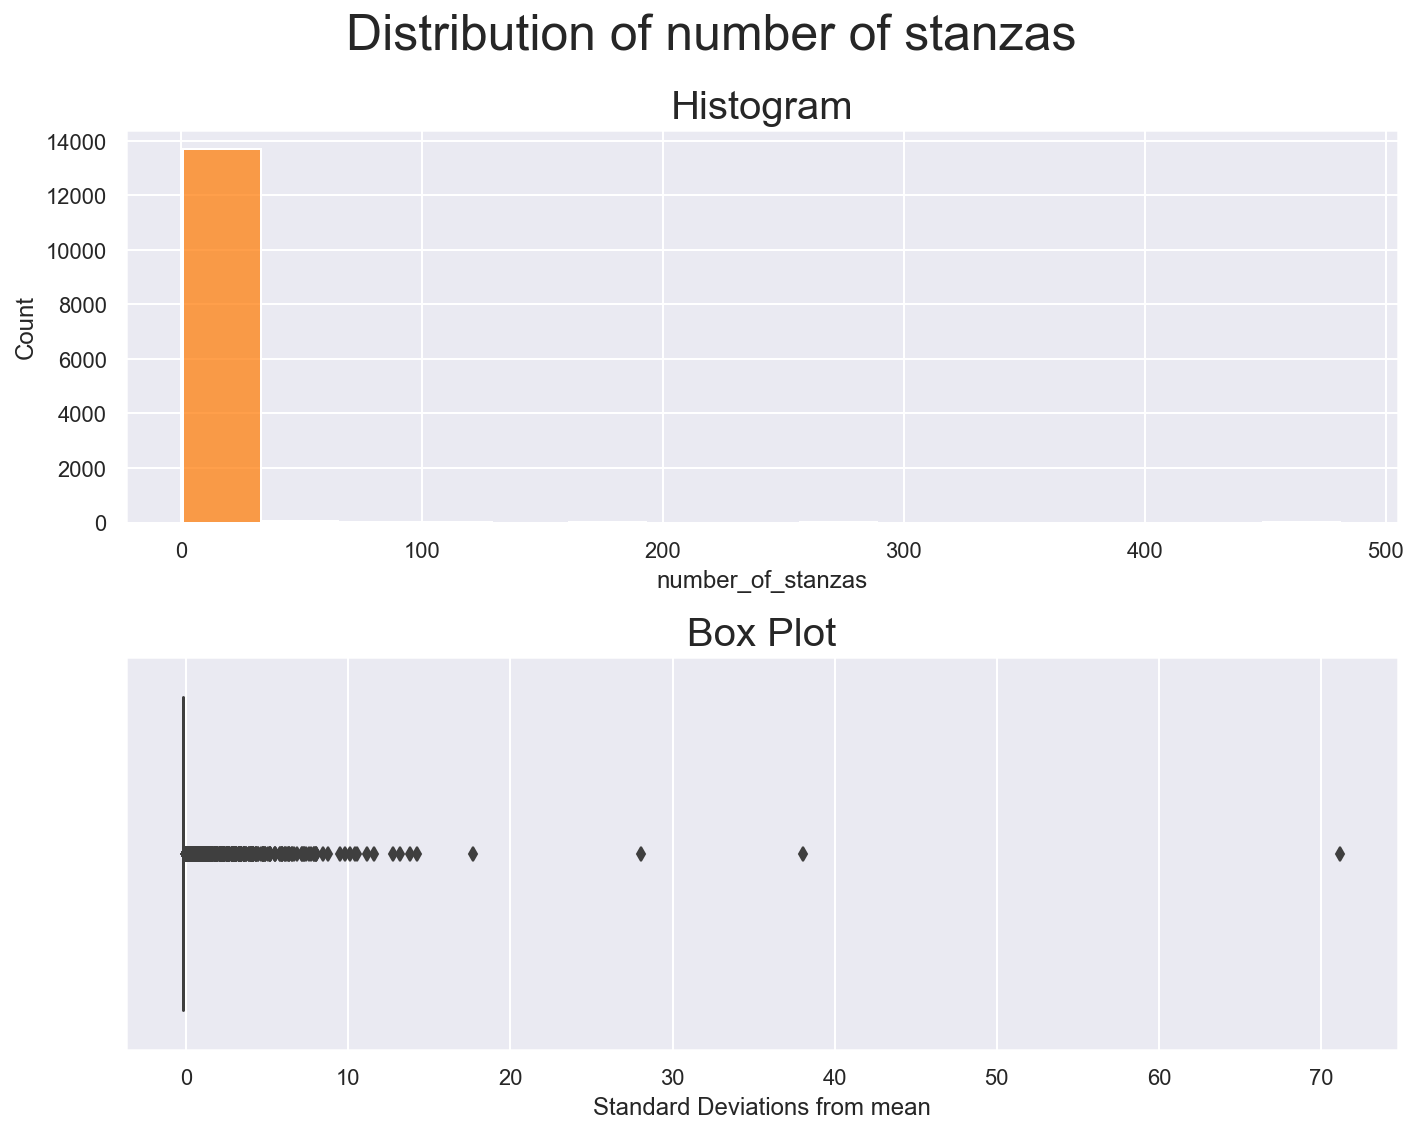

In [56]:
fig, ax = plt.subplots(nrows = 2, figsize = (10,8))

sns.histplot(poems.number_of_stanzas, color = 'tab:orange', ax=ax[0])
sns.boxplot(var_standardize(poems.number_of_stanzas), color = 'tab:blue', ax=ax[1])

ax[0].set_title('Histogram', fontsize = 20)
ax[1].set_title('Box Plot', fontsize = 20)

ax[1].set_xlabel('Standard Deviations from mean')

plt.suptitle('Distribution of number of stanzas', fontsize = 25)
plt.tight_layout()
plt.show();

The above plots just reaffirm what the `.describe()` table tells us. This column is dominated by poems with few stanzas. 

Because of this dominance, I am not concerned by the poems with a number of stanzas up to 20 standard deviations away from the mean.

I will still investigate the three poems with much more stanzas just to confirm this is legitimate.

In [7]:
poems[var_standardize(poems.number_of_stanzas) > 20][['title','poet','number_of_stanzas']]

title              poet  number_of_stanzas
818            Bridge of the World  Roberto Harrison                191
1195                      The Vein       Tom Raworth                258
11316  The Third Hour of the Night      Frank Bidart                481

After investigating these poems, I can confirm the shape of each poem has a large number of stanzas - indeed I think the poets are trying to say something by the way they have structured these poems 9I'm not going to go into it though).

I don't think the values for these poems are unreliable and I will not change them.

# Conclusion

My preliminary analysis has led me to draw the following conclusions:
1. The class imbalance in the `country_of_origin` columns for this dataset has led me to aggregate the countries by their continent and use this as my target variable instead.
2. There is moderate class imbalance within the `sex` target column, with male being the largest class. This imbalance is not so drastic that I cannot build my model using this target variable.
3. The `dates` column has a negative skew, with most values falling between 1900 and 2000.
4. After investigating several outliers for the `dates` column, I can confirm they are legitimate values and will be kept in the dataset.
5. The `number_of_lines` and `number_of_stanzas` columns are both positively skewed, and are heavily dominated by lower values - this means legitimate higher values are being flagged as outliers.
6. After investigating several of these outlier I can confirm they are legitimate recordings and will remain within the dataset.